Total Distance: 100.0 

Route for vehicle 1: [0, 2, 3, 0]
Total Distance for vehicle 1: 50
Route for vehicle 2: [0, 1, 4, 0]
Total Distance for vehicle 2: 50




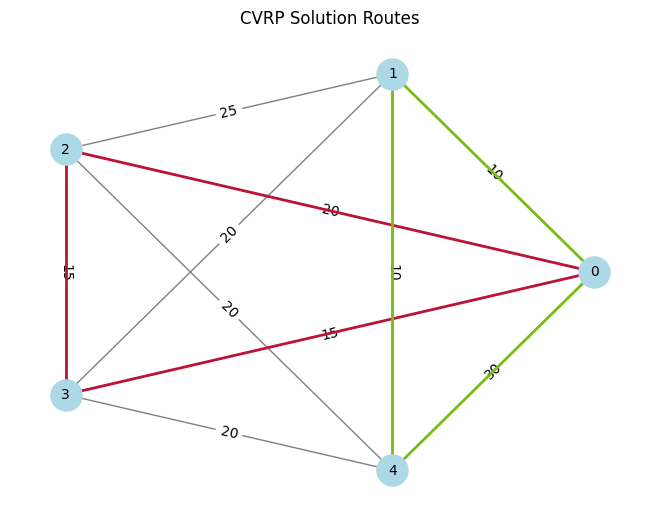

In [34]:
# !pip install pulp
from pulp import *
import matplotlib.pyplot as plt
import networkx as nx

def solve_CVRP_with_pulp(distance_matrix, demand, vehicle_capacity, num_vehicles, depot=0, show_model=False, show_plot=True):
    num_locations = len(distance_matrix)
    locations = range(num_locations)

    # Initialize the problem
    cvrp_model = LpProblem("CVRP", LpMinimize)

    # Decision variables: x[i][j][k] = 1 if vehicle k travels from location i to location j, else 0
    x = LpVariable.dicts("x", ((i, j, k) for i in locations for j in locations for k in range(num_vehicles)), cat="Binary")

    # Auxiliary variables to avoid sub-tours
    u = LpVariable.dicts("u", (i for i in locations if i != depot), lowBound=0, upBound=vehicle_capacity, cat="Continuous")

    # Objective function: minimize the total travel distance
    cvrp_model += lpSum(distance_matrix[i][j] * x[i, j, k] for i in locations for j in locations if i != j for k in range(num_vehicles)), "Total_Distance"

    # Constraints

    # 1. Each customer is visited exactly once by one vehicle
    for j in locations:
        if j != depot:
            cvrp_model += lpSum(x[i, j, k] for i in locations if i != j for k in range(num_vehicles)) == 1, f"Visit_{j}"

    # 2. Flow conservation for each vehicle: if a vehicle arrives at a location, it must leave that location
    for k in range(num_vehicles):
        for i in locations:
            if i != depot:
                cvrp_model += lpSum(x[i, j, k] for j in locations if i != j) == lpSum(x[j, i, k] for j in locations if i != j), f"Flow_{i}_{k}"

    # 3. Vehicle capacity constraint
    for k in range(num_vehicles):
        cvrp_model += lpSum(demand[j] * x[i, j, k] for i in locations for j in locations if i != j and j != depot) <= vehicle_capacity, f"Capacity_{k}"

    # 4. Depot start and end constraint for each vehicle
    for k in range(num_vehicles):
        cvrp_model += lpSum(x[depot, j, k] for j in locations if j != depot) == 1, f"Start_{k}"
        cvrp_model += lpSum(x[i, depot, k] for i in locations if i != depot) == 1, f"End_{k}"

    # 5. Subtour elimination constraints
    for i in locations:
        if i != depot:
            for j in locations:
                if i != j and j != depot:
                    for k in range(num_vehicles):
                        cvrp_model += u[i] - u[j] + vehicle_capacity * x[i, j, k] <= vehicle_capacity - demand[j], f"Subtour_{i}_{j}_{k}"

    # Solve the model
    cvrp_model.solve()

    # Show model details if requested
    if show_model:
        print("\nModel Summary:\n")
        print(cvrp_model)

    # Retrieve and print the solution
    if cvrp_model.status == LpStatusOptimal:
        print("Total Distance:", value(cvrp_model.objective), "\n")

        # Extract the solution routes for each vehicle
        routes = {k: [] for k in range(num_vehicles)}
        distances = {k: 0 for k in range(num_vehicles)}  # Store total distance for each vehicle
        edges = {(i, j, k): value(x[i, j, k]) for i in locations for j in locations for k in range(num_vehicles)}

        # Build the routes based on the edges where x[i, j, k] == 1
        for k in range(num_vehicles):
            route = [depot]
            total_distance = 0
            current_location = depot
            while True:
                next_location = next((j for (i, j, k_) in edges if i == current_location and edges[(i, j, k)] == 1), None)
                if next_location is None or next_location == depot:
                    break
                route.append(next_location)
                total_distance += distance_matrix[current_location][next_location]
                current_location = next_location
            route.append(depot)
            total_distance += distance_matrix[current_location][depot]  # Add return to depot
            routes[k] = route
            distances[k] = total_distance
            print(f"Route for vehicle {k + 1}: {route}")
            print(f"Total Distance for vehicle {k + 1}: {total_distance}")

        # Plot the routes if requested
        if show_plot:
          print("\n")
          plot_cvrp_solution(distance_matrix, routes)
    else:
        print("No optimal solution found.")

def plot_cvrp_solution(distance_matrix, routes):
    G = nx.Graph()
    num_locations = len(distance_matrix)

    for i in range(num_locations):
        for j in range(i + 1, num_locations):
            if distance_matrix[i][j] > 0:
                G.add_edge(i, j, weight=distance_matrix[i][j])

    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f"{distance_matrix[i][j]}" for i, j in G.edges()})

    colors = ["#bd1435", "#78bd14", "#1497bd", "purple", "orange", "pink"]
    for k, route in routes.items():
        route_edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=route_edges, width=2, edge_color=colors[k % len(colors)])

    plt.title("CVRP Solution Routes")
    plt.show()

# Example usage
if __name__ == "__main__":
  distance_matrix = [
    [0, 10, 20, 15, 30],
    [10, 0, 25, 20, 10],
    [20, 25, 0, 15, 20],
    [15, 20, 15, 0, 20],
    [30, 10, 20, 20, 0]
    ]
  demand = [0, 10, 20, 30, 40]  # 0 demand for the depot
  vehicle_capacity = 50
  num_vehicles = 2

  solve_CVRP_with_pulp(distance_matrix, demand, vehicle_capacity, num_vehicles, show_model=False, show_plot=True)